# Aggregate Investor Allocation to Equities (AIAE) Indicator 
#### Inspired by the work of: https://www.philosophicaleconomics.com/2013/12/the-single-greatest-predictor-of-future-stock-market-returns/
#### This indicator has shown to empirically outperform other indicators such as PE and CAPE in predicting 10yr index returns

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [233]:
# Using Yahoo Finance (Data only from 1993):
# df = yf.download('SPY', period='max', interval='1mo')['Adj Close']
# df = pd.DataFrame(df)
# df.rename(columns={'Adj Close':'SPX_Price'}, inplace=True)

df = pd.read_csv('MacroPrices.csv')
df.set_index('Dates', inplace=True)
df = pd.DataFrame(df.loc[:,'S&P500'])
df.dropna(inplace=True)

df.index = pd.to_datetime(df.index)
df = df.loc[df.groupby(df.index.to_period('Y')).apply(lambda x: x.index.max())]
df['RollingReturn'] = float(0)
for i in range(0, df.shape[0]-10): 
    df['RollingReturn'][i] = ((df['S&P500'][i+10]-df['S&P500'][i])/df['S&P500'][i])/10
df.dropna(inplace=True)
df.index = df.index.year
df = df.iloc[23:-1, :] #only have data from 1950-2022 from FRED
df

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,S&P500,RollingReturn
Dates,,
1950,20.43,0.184435
1951,23.77,0.201010
1952,26.57,0.137486
1953,24.81,0.202378
1954,35.98,0.135548
...,...,...
2018,2506.85,0.000000
2019,3230.78,0.000000
2020,3756.07,0.000000


#### FRED API: https://fred.stlouisfed.org/docs/api/fred/

In [234]:
codes = ['NCBEILQ027S','BCNSDODNS','CMDEBT','FGSDODNS', 'SLGSDODNS', 'FBCELLQ027S', 'DODFFSWCMI']
end_date = dt.datetime.today()
start_date = dt.datetime(1950, 1, 1)
fred_df = pd.DataFrame()

for code in codes:
    reader = pdr.fred.FredReader(code, start_date, end_date)
    df0 = reader.read()
    fred_df = fred_df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)
    reader.close()
fred_df.dropna(axis=0, inplace = True)
fred_df.rename(columns={'NCBEILQ027S':'Nonfin_eq','BCNSDODNS':'Nonfin_liabs','CMDEBT':'Hhold_debt','FGSDODNS':'FedDebt', 
                   'SLGSDODNS':'Gov_debt', 'FBCELLQ027S':'Fin_eq', 'DODFFSWCMI':'ROW_debt'}, inplace=True)

fred_df['AIAE_Indicator'] = (((fred_df['Nonfin_eq']+fred_df['Fin_eq'])/1000)/
                             (((fred_df['Nonfin_eq']+fred_df['Fin_eq'])/1000)+
                              fred_df['Nonfin_liabs'] + fred_df['Hhold_debt']+ 
                              fred_df['FedDebt']+ fred_df['Gov_debt']+fred_df['ROW_debt']))/10

fred_df.index = pd.to_datetime(fred_df.index)
fred_df = fred_df.loc[fred_df.groupby(fred_df.index.to_period('Y')).apply(lambda x: x.index.max())]
fred_df.index = fred_df.index.year
fred_df

,Nonfin_eq,Nonfin_liabs,Hhold_debt,FedDebt,Gov_debt,Fin_eq,ROW_debt,AIAE_Indicator
DATE,,,,,,,,
1950,126681.0,70.439,74.845,223.234,21.210,49672.0,13.614,0.030422
1951,147629.0,78.868,83.447,223.506,23.586,50063.0,14.213,0.031818
1952,146628.0,85.098,95.595,229.829,30.795,50591.0,14.765,0.030188
1953,144082.0,89.252,108.158,237.379,35.786,50992.0,15.887,0.028623
1954,194840.0,92.843,120.453,240.195,41.102,51649.0,15.986,0.032558
...,...,...,...,...,...,...,...,...
2018,26543606.0,9680.002,15602.456,17865.026,3115.384,9272131.0,3891.069,0.041661
2019,33680489.0,10326.778,16094.783,19039.898,3113.896,11485509.0,4248.605,0.046092
2020,42497994.0,11397.544,16711.069,23621.060,3205.424,12410168.0,4508.742,0.048017


In [235]:
df2 = fred_df['AIAE_Indicator']
df2 = pd.DataFrame(df2)

df3 = df2.merge(df, how='inner', left_index=True, right_index=True)
df3.drop(columns=['S&P500'], inplace=True)
df3.iloc[-9:,1] = np.nan 
df3

,AIAE_Indicator,RollingReturn
DATE,,
1950,0.030422,0.184435
1951,0.031818,0.201010
1952,0.030188,0.137486
1953,0.028623,0.202378
1954,0.032558,0.135548
...,...,...
2018,0.041661,NaN
2019,0.046092,NaN
2020,0.048017,NaN


Text(0.5, 1.0, 'AIAE Indicator')

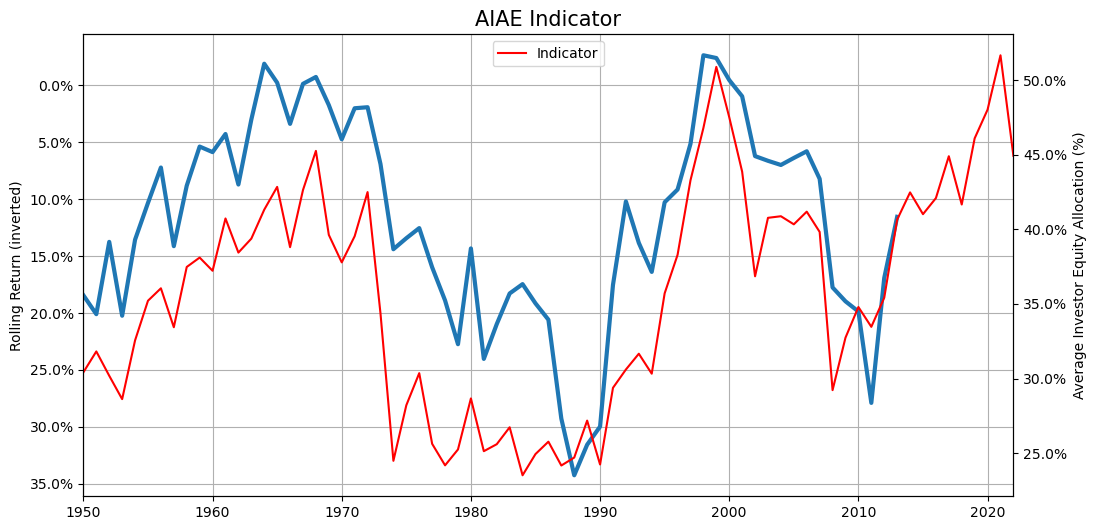

In [236]:
fig, ax = plt.subplots(figsize=(12,6), sharey=False)
l1 = ax.plot(df3['RollingReturn'], label='10yr Rolling (subsequant) Return', lw=3.0)
ax.set_ylabel('Rolling Return (inverted)')
plt.gca().invert_yaxis()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax.grid()
ax2 = ax.twinx()
l2 = ax2.plot(df3['AIAE_Indicator']*10, label='Indicator', c='r')
ax2.set_ylabel('Average Investor Equity Allocation (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.xlim(df3.index[0], df3.index[-1])
plt.legend(loc='upper center')
plt.title('AIAE Indicator', fontsize=15)

##### **Discrepency versus reference paper due to the use of price return rather than total return.

# OLS Regression using Numpy and SKLearn

R-squared: 0.768


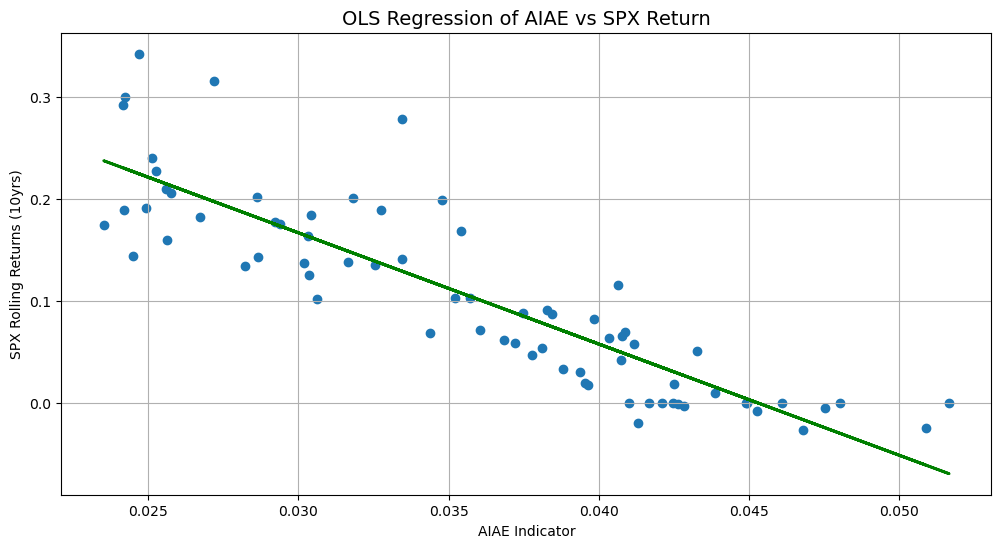

In [237]:
df3.iloc[-9:,1] = float(0)
x = np.array(df3['AIAE_Indicator'])
y = np.array(df3['RollingReturn'])

reg = np.polyfit(x, y, deg=1)
plt.figure(figsize=(12,6))
plt.scatter(x, y)
plt.plot(x, np.polyval(reg, x), 'green', lw=2.0) #line of best fit
plt.xlabel("AIAE Indicator")
plt.ylabel("SPX Rolling Returns (10yrs)")
plt.title("OLS Regression of AIAE vs SPX Return", size=14)
plt.grid()
print(f"R-squared: {round(np.corrcoef(x, y)[0,1]**2,3)}")

In [238]:
scaler = StandardScaler()
scaler.fit(df3)
scaled_df = scaler.transform(df3)
scaled_df
Y = scaled_df[:,1]
X_arr = scaled_df[:,0]
X_arr = X_arr.reshape(-1,1)
print("X:\n",X_arr[:5], "\nY:\n", Y[:5])

X:
 [[-0.72102774]
 [-0.53231477]
 [-0.75258984]
 [-0.96408005]
 [-0.43235117]] 
Y:
 [0.87106568 1.05091124 0.36165292 1.06575889 0.34062095]


In [239]:
r_score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_arr, Y)
    model = LinearRegression()
    train = model.fit(X_train, y_train)
    train_score = model.score(X=X_train, y=y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    r_score.append(r2)
print(f"Max R2 score: {round(max(r_score),3)}\nMin R2 score: {round(min(r_score),3)}\nAverage R2 Score: {round(sum(r_score)/len(r_score),3)} ")

Max R2 score: 0.844
Min R2 score: 0.618
Average R2 Score: 0.759 


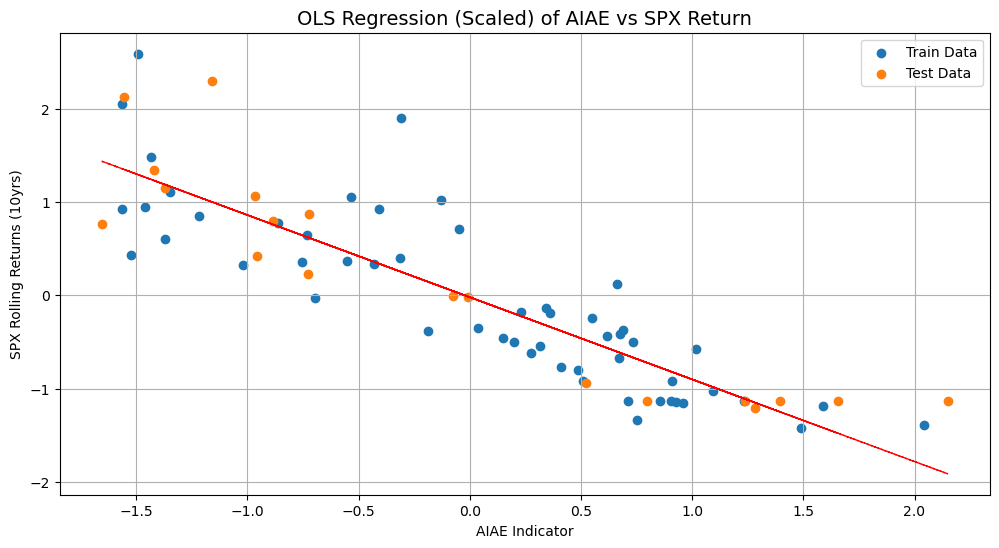

In [240]:
plt.figure(figsize=(12,6))
plt.scatter(X_train, y_train, label='Train Data')
plt.scatter(X_test, y_test, label='Test Data')
plt.plot(X_test, y_pred, c="r", lw=1, ls='--')
plt.xlabel("AIAE Indicator")
plt.ylabel("SPX Rolling Returns (10yrs)")
plt.title("OLS Regression (Scaled) of AIAE vs SPX Return", size=14)
plt.grid()
plt.legend(loc=0)

### Comparing to the CAPE Ratio:

In [241]:
cape_df = pd.read_csv('CAPE.csv')
cape_df.set_index('Date', inplace=True)
cape_df.dropna(inplace=True)

cape_df.index = pd.to_datetime(cape_df.index)
cape_df = cape_df.loc[cape_df.groupby(cape_df.index.to_period('Y')).apply(lambda x: x.index.max())]
cape_df['RollingReturn'] = float(0)
for i in range(0, cape_df.shape[0]-10): 
    cape_df['RollingReturn'][i] = ((cape_df['S&P500'][i+10]-cape_df['S&P500'][i])/cape_df['S&P500'][i])/10
cape_df.dropna(inplace=True)
cape_df.index = cape_df.index.year
cape_df = cape_df.iloc[69:-1, :] #aligning time frames with AIAE
cape_df

,S&P500,CAPE,RollingReturn
Date,,,
1950,19.75,11.31,0.187595
1951,23.41,12.15,0.206450
1952,26.04,12.93,0.140553
1953,24.83,11.75,0.198711
1954,34.97,15.79,0.140092
...,...,...,...
2018,2567.31,28.29,0.000000
2019,3176.75,30.33,0.000000
2020,3695.31,33.77,0.000000


R-squared: 0.448


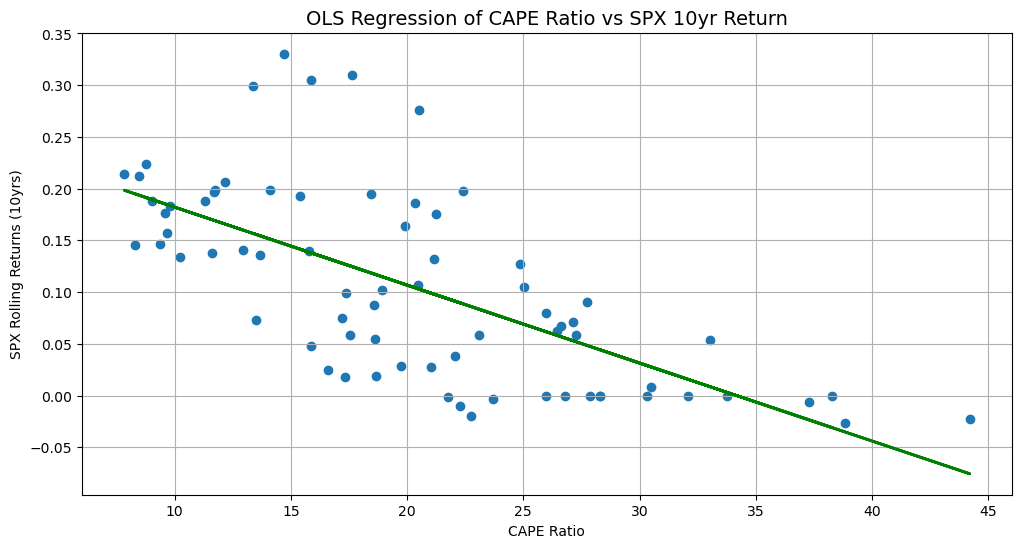

In [242]:
cape_x = np.array(cape_df['CAPE'])
cape_y = np.array(cape_df['RollingReturn'])

reg = np.polyfit(cape_x, cape_y, deg=1)
plt.figure(figsize=(12,6))
plt.scatter(cape_x, cape_y)
plt.plot(cape_x, np.polyval(reg, cape_x), 'green', lw=2.0) #line of best fit
plt.xlabel("CAPE Ratio")
plt.ylabel("SPX Rolling Returns (10yrs)")
plt.title("OLS Regression of CAPE Ratio vs SPX 10yr Return", size=14)
plt.grid()
print(f"R-squared: {round(np.corrcoef(cape_x, cape_y)[0,1]**2,3)}")

In [243]:
scaler = StandardScaler()
scaler.fit(cape_df)
scaled_df2 = scaler.transform(cape_df)

cape_Y = scaled_df2[:,2]
X_cape = scaled_df2[:,1]
X_cape = X_cape.reshape(-1,1)
print("X:\n",X_cape[:5], "\nY:\n", cape_Y[:5])

X:
 [[-1.09962467]
 [-0.99669065]
 [-0.90110907]
 [-1.04570685]
 [-0.55064326]] 
Y:
 [0.90274753 1.10794206 0.39080925 1.02372169 0.38578706]


In [244]:
r_score = []
for i in range(10):
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cape, cape_Y)
    model = LinearRegression()
    train = model.fit(Xc_train, yc_train)
    train_score = model.score(X=X_train, y=yc_train)
    yc_pred = model.predict(Xc_test)
    
    r2 = r2_score(yc_test, yc_pred)
    r_score.append(r2)
print(f"Max R2 score: {round(max(r_score),3)}\nMin R2 score: {round(min(r_score),3)}\nAverage R2 Score: {round(sum(r_score)/len(r_score),3)} ")

Max R2 score: 0.651
Min R2 score: 0.264
Average R2 Score: 0.459 


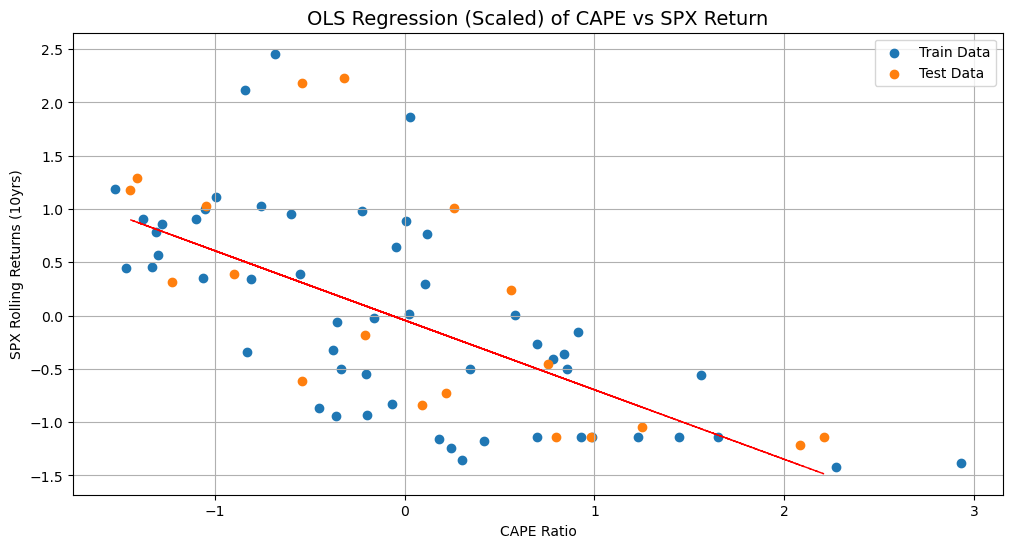

In [245]:
plt.figure(figsize=(12,6))
plt.scatter(Xc_train, yc_train, label='Train Data')
plt.scatter(Xc_test, yc_test, label='Test Data')
plt.plot(Xc_test, yc_pred, c="r", lw=1, ls='--')
plt.xlabel("CAPE Ratio")
plt.ylabel("SPX Rolling Returns (10yrs)")
plt.title("OLS Regression (Scaled) of CAPE vs SPX Return", size=14)
plt.grid()
plt.legend(loc=0)